In [67]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas_profiling

In [5]:
# use the 'seaborn-colorblind' style
plt.style.use('seaborn-colorblind')

In [6]:
#load data 
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


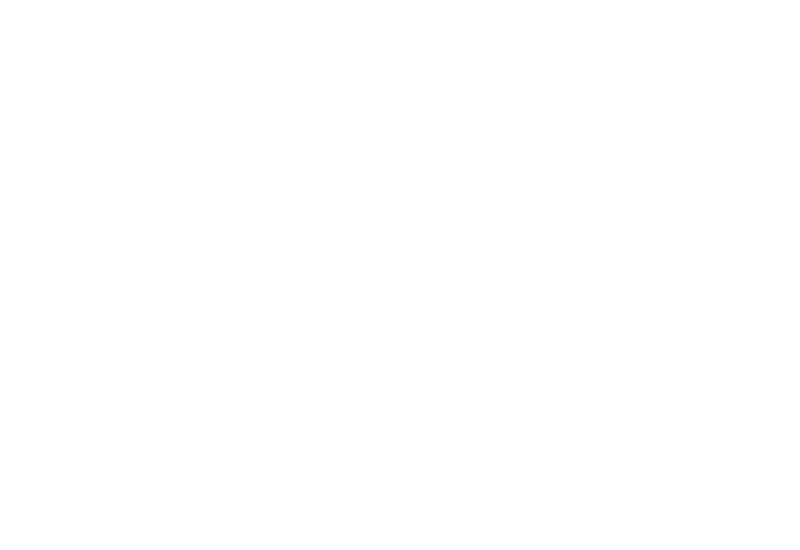

<IPython.core.display.Javascript object>


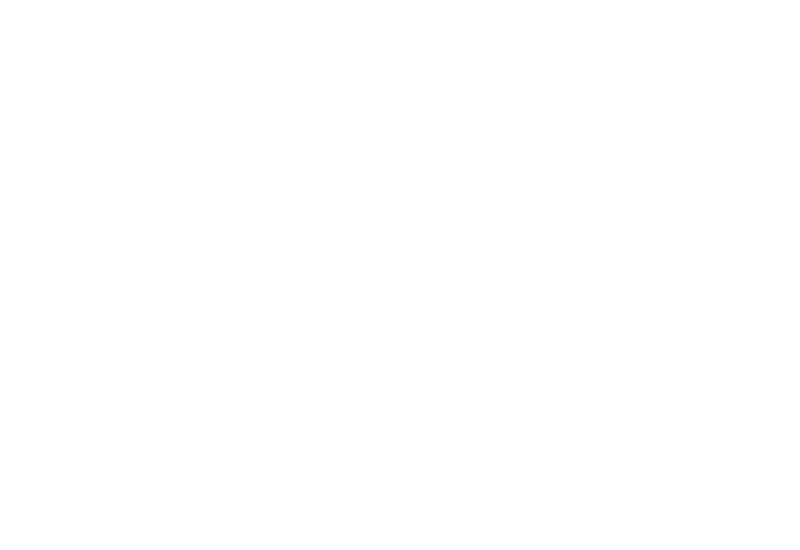

<IPython.core.display.Javascript object>


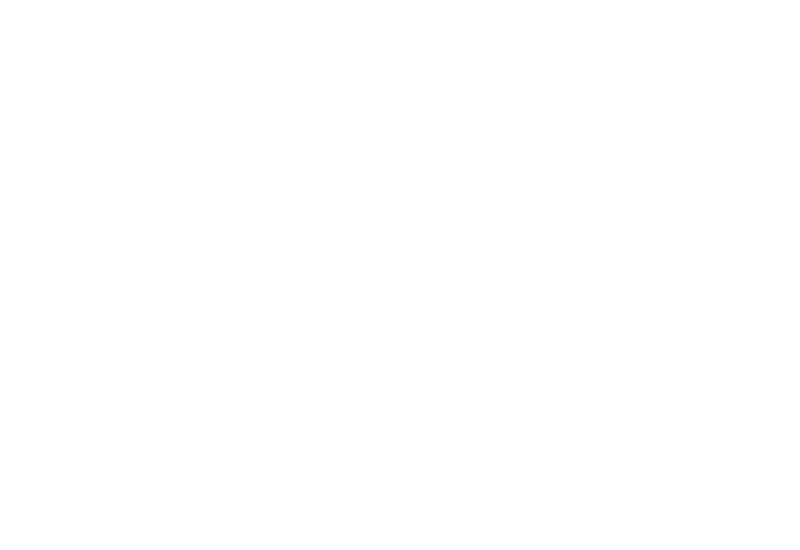

<IPython.core.display.Javascript object>


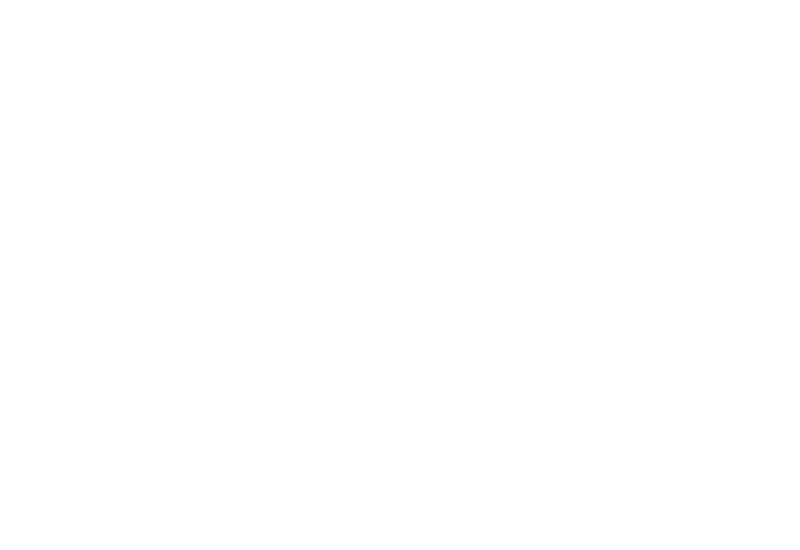

<IPython.core.display.Javascript object>


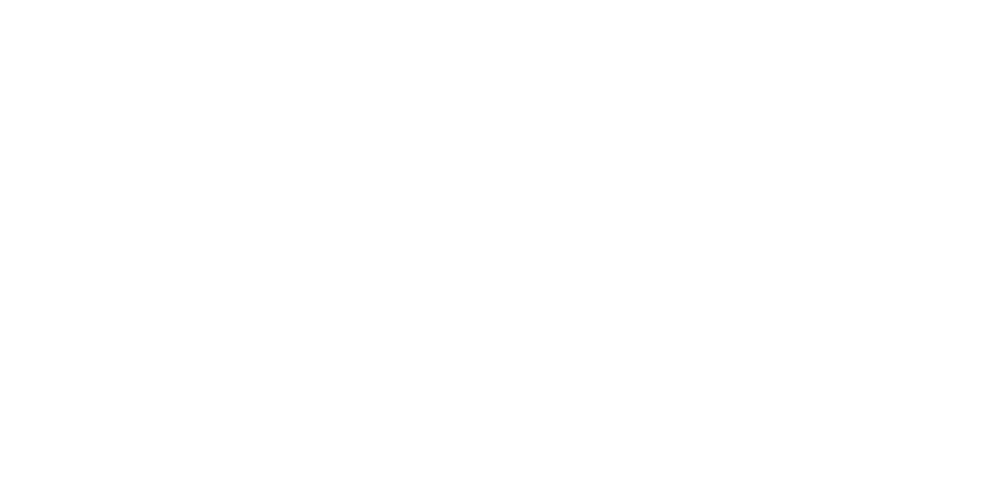

<IPython.core.display.Javascript object>


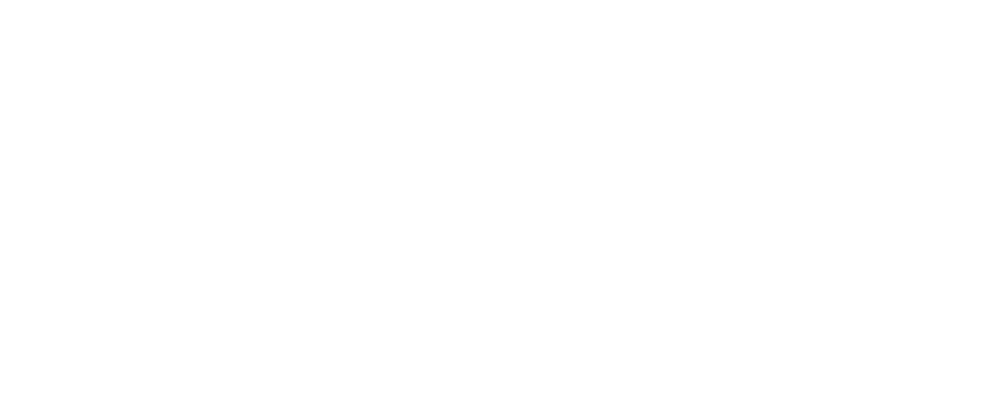

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


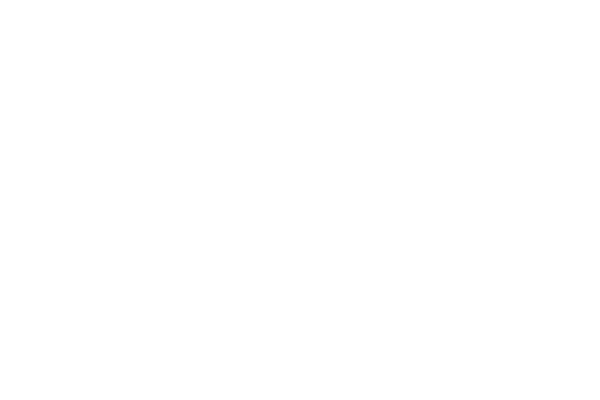

<IPython.core.display.Javascript object>


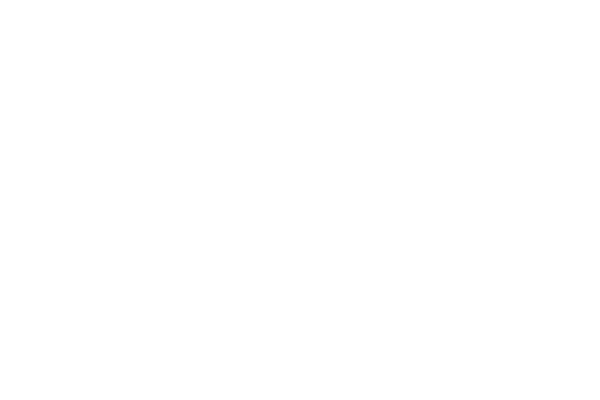

<IPython.core.display.Javascript object>


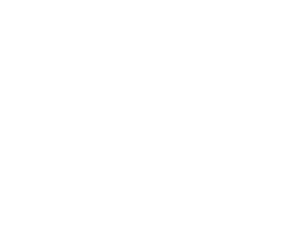

<IPython.core.display.Javascript object>


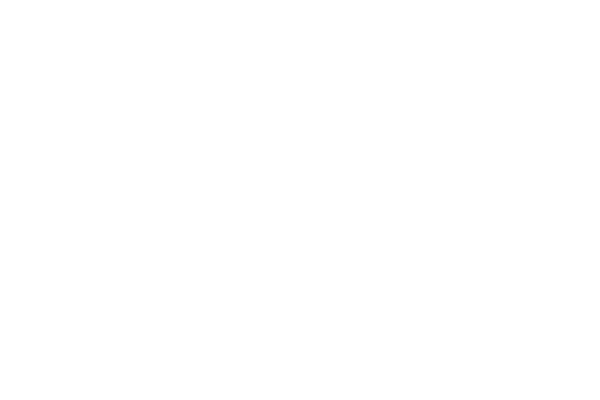

<IPython.core.display.Javascript object>


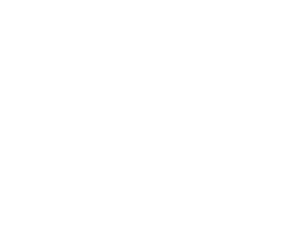

<IPython.core.display.Javascript object>


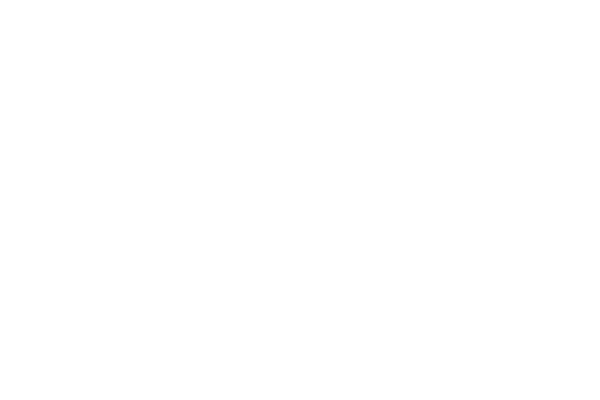

<IPython.core.display.Javascript object>


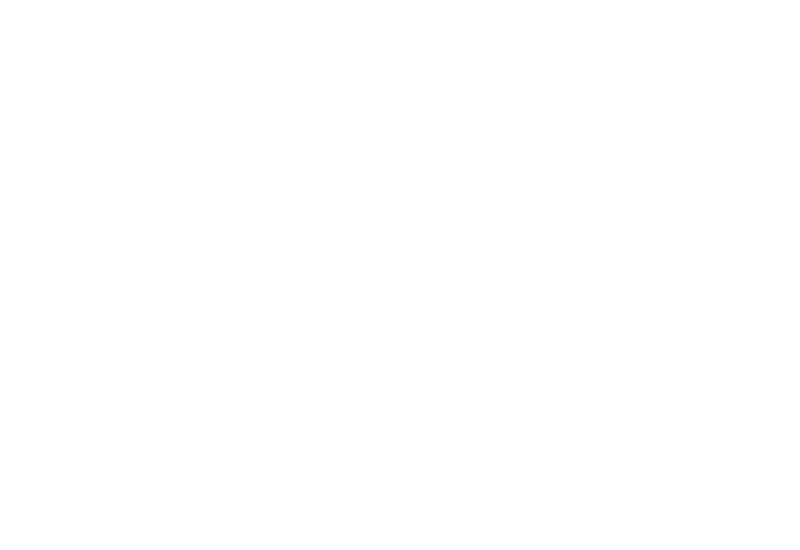

<IPython.core.display.Javascript object>


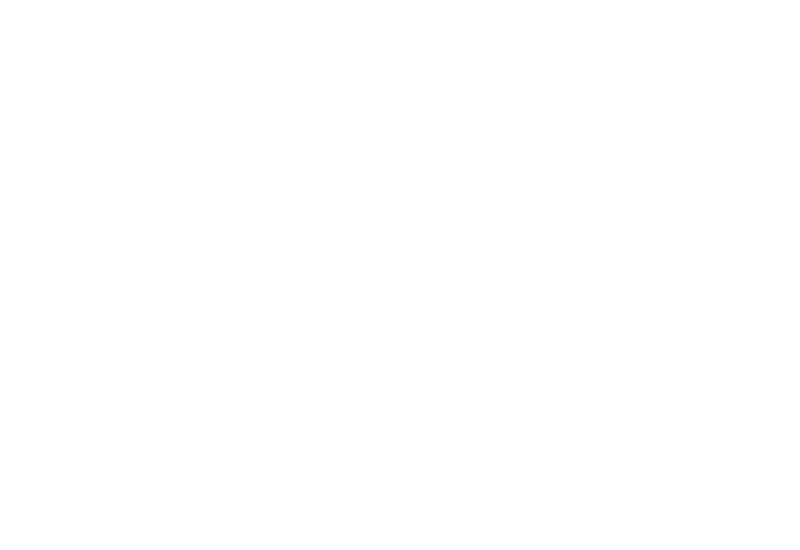

<IPython.core.display.Javascript object>


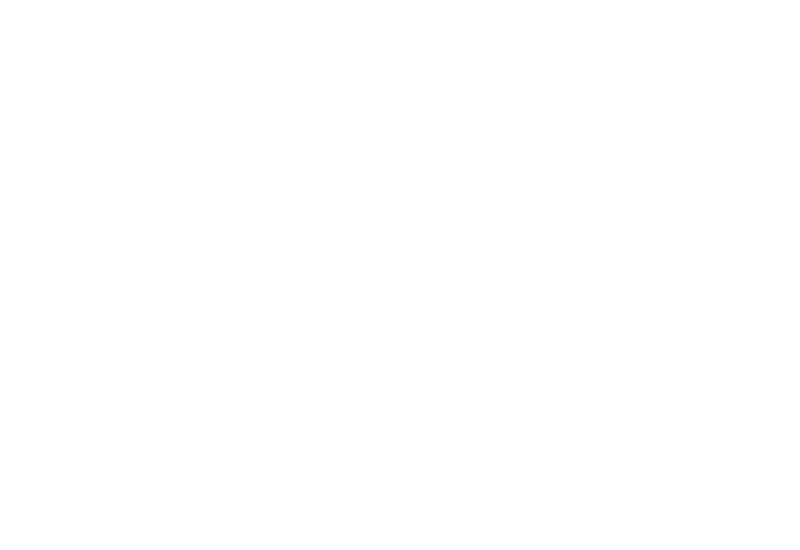

<IPython.core.display.Javascript object>


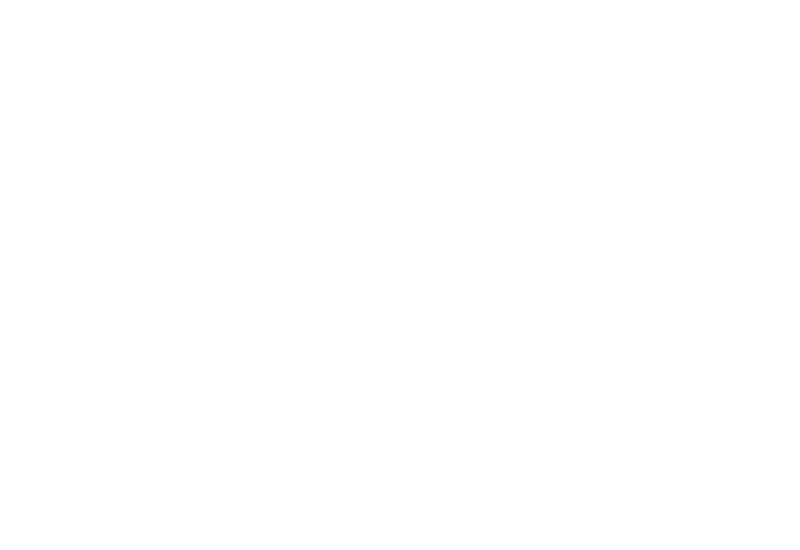

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [382]:
#Generates profile reports from train data
pandas_profiling.ProfileReport(train_df)

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


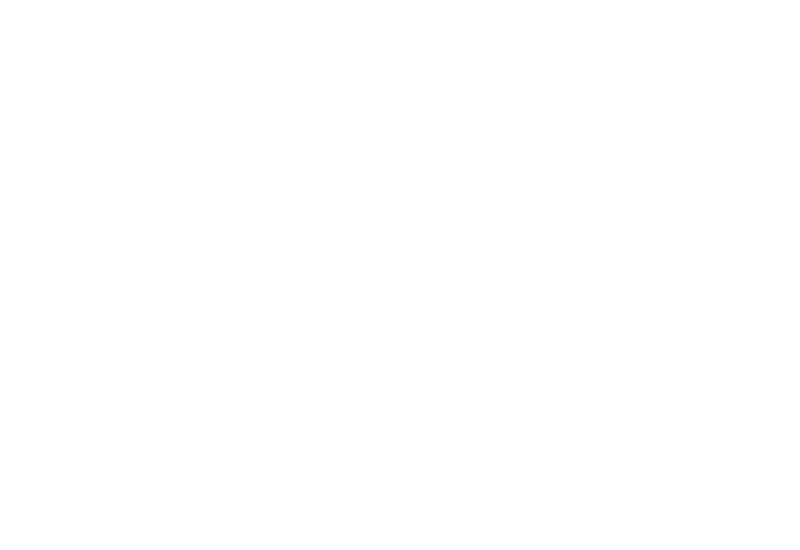

<IPython.core.display.Javascript object>


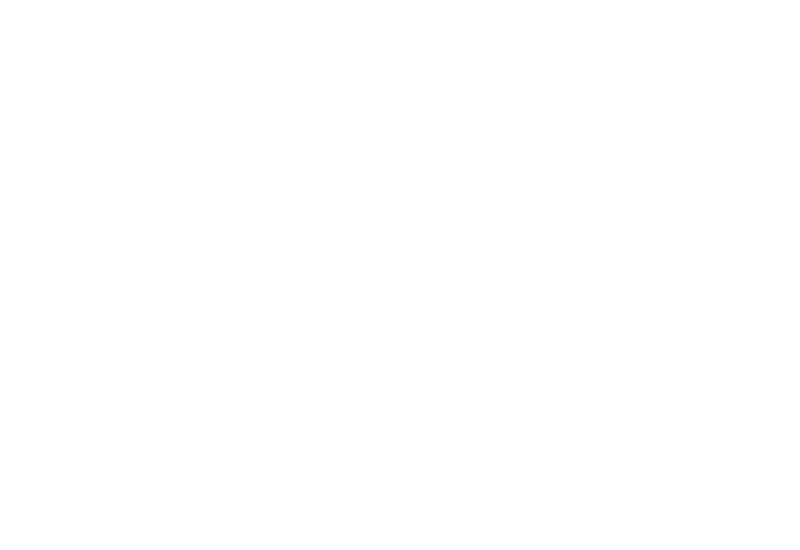

<IPython.core.display.Javascript object>


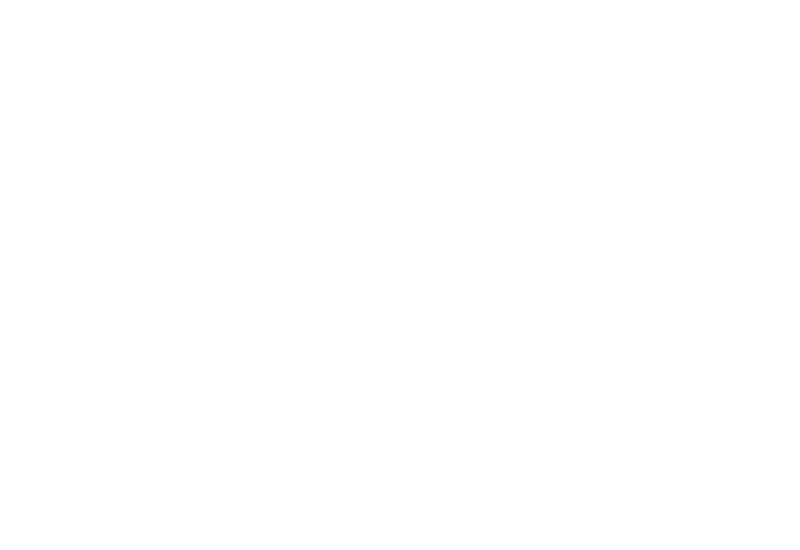

<IPython.core.display.Javascript object>


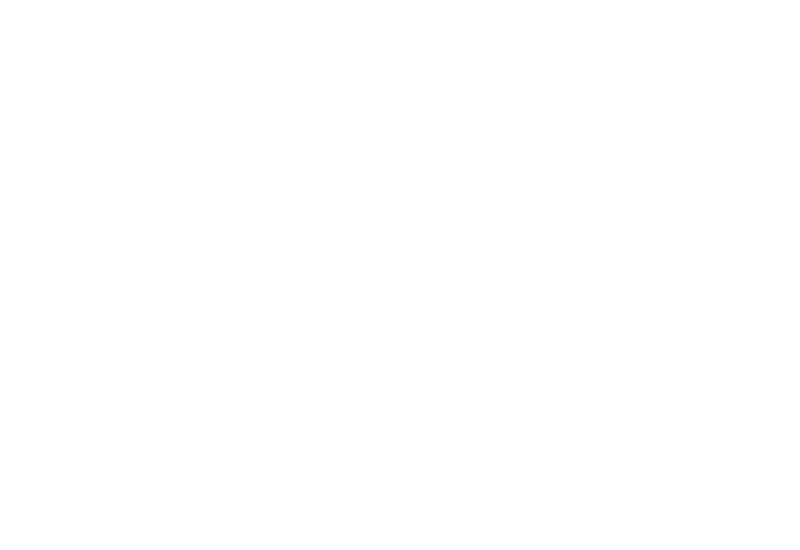

<IPython.core.display.Javascript object>


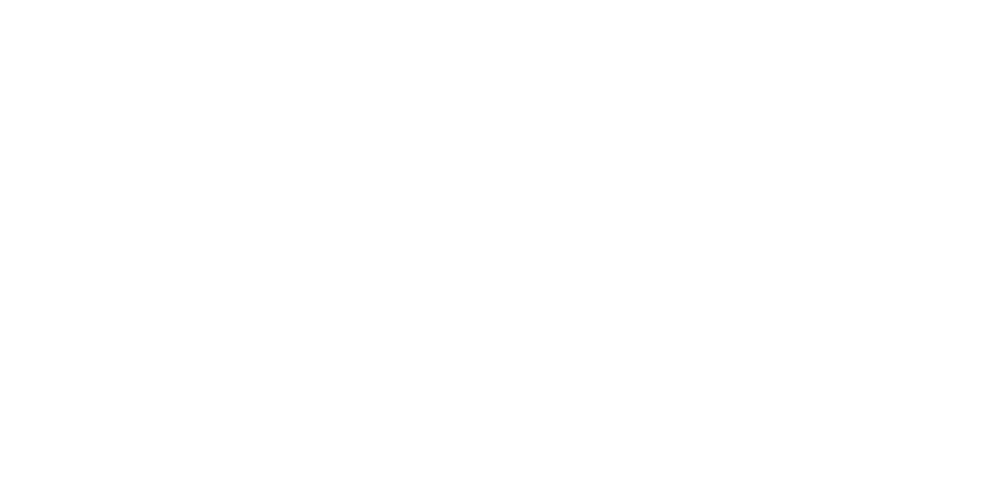

<IPython.core.display.Javascript object>


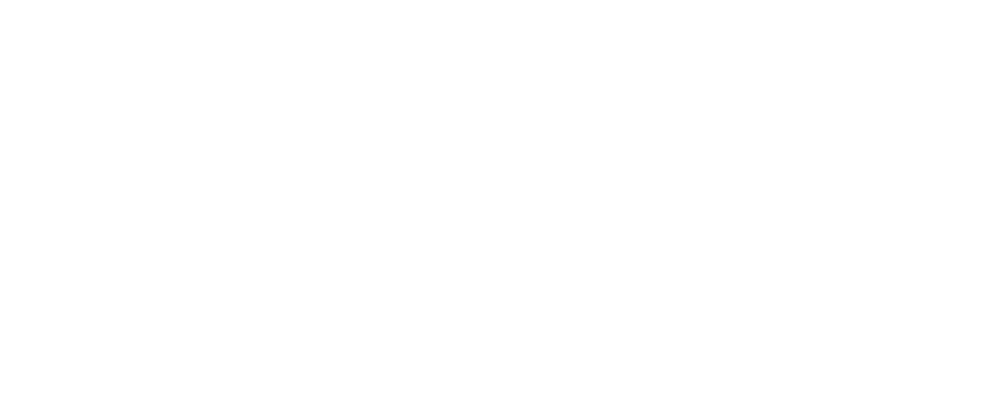

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


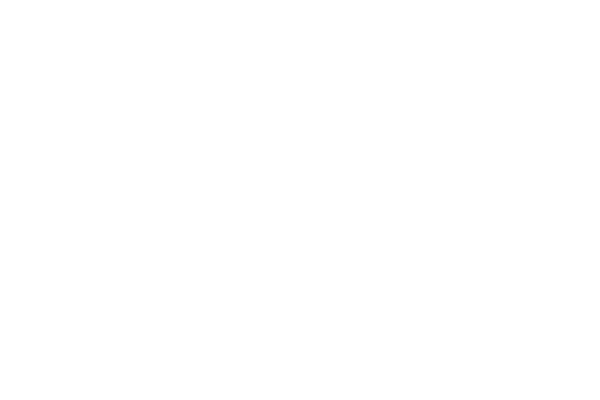

<IPython.core.display.Javascript object>


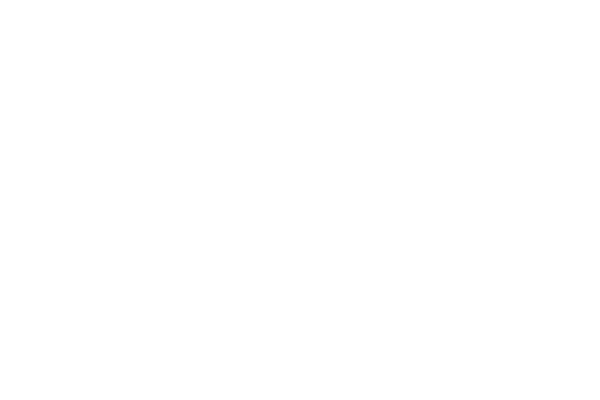

<IPython.core.display.Javascript object>


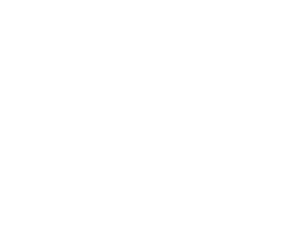

<IPython.core.display.Javascript object>


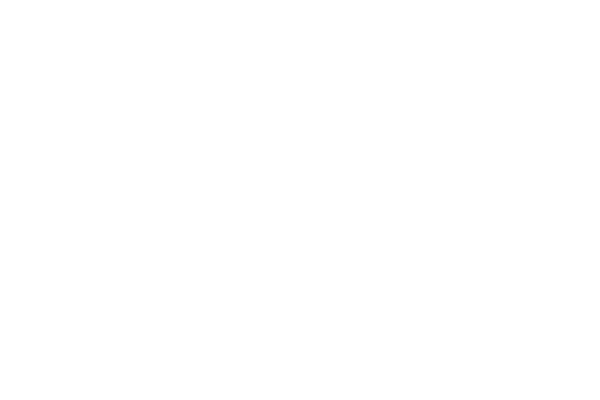

<IPython.core.display.Javascript object>


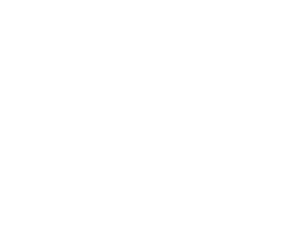

<IPython.core.display.Javascript object>


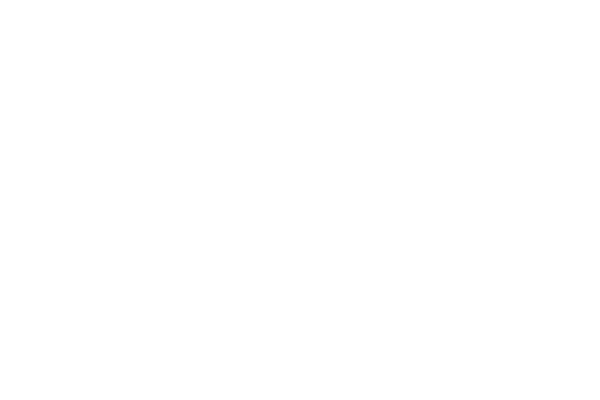

<IPython.core.display.Javascript object>


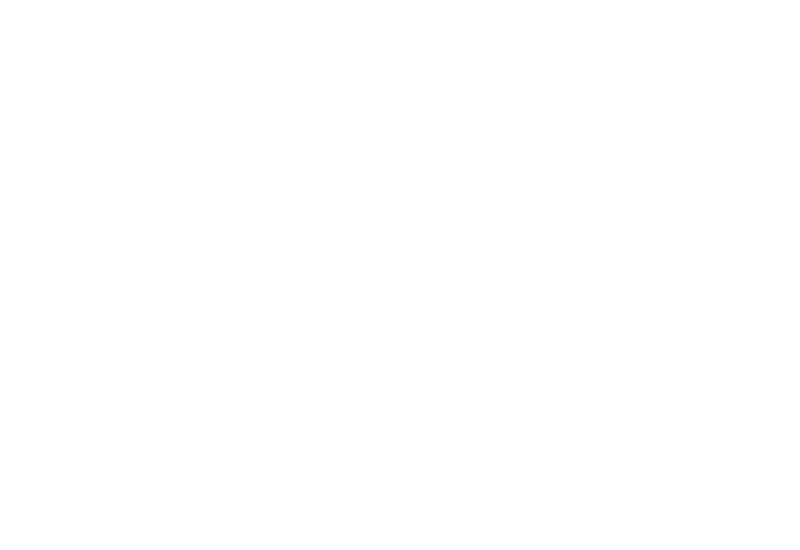

<IPython.core.display.Javascript object>


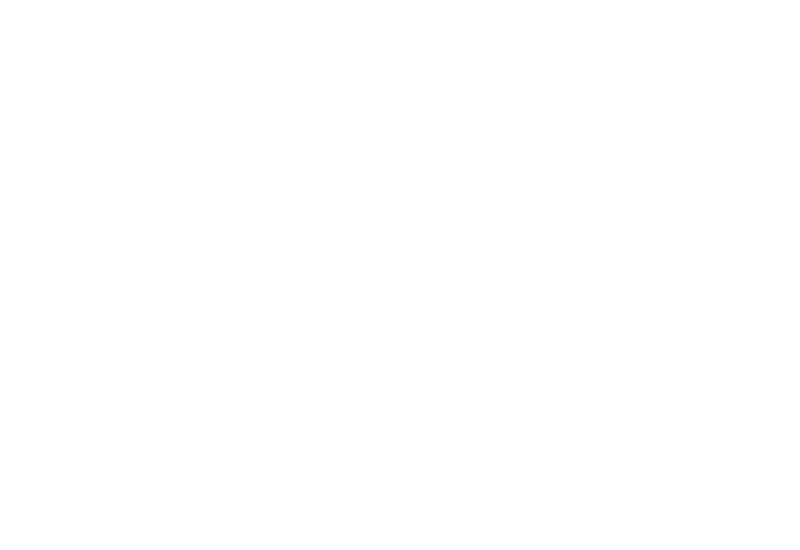

<IPython.core.display.Javascript object>


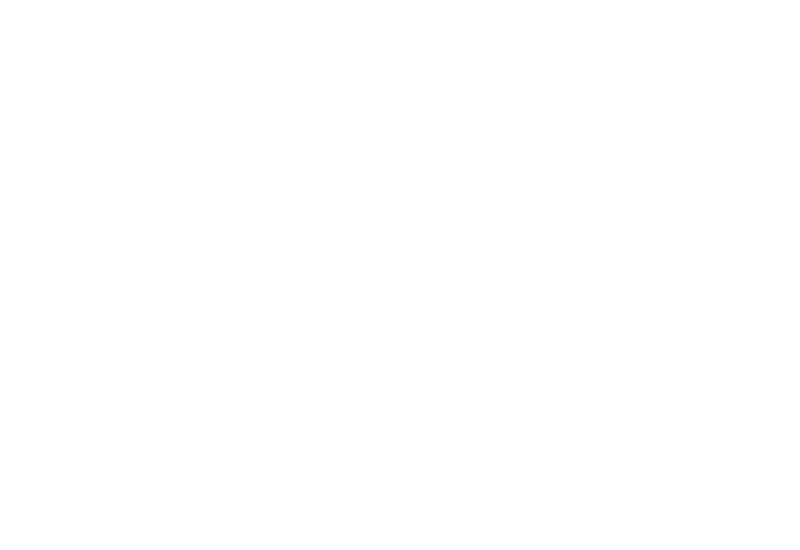

<IPython.core.display.Javascript object>


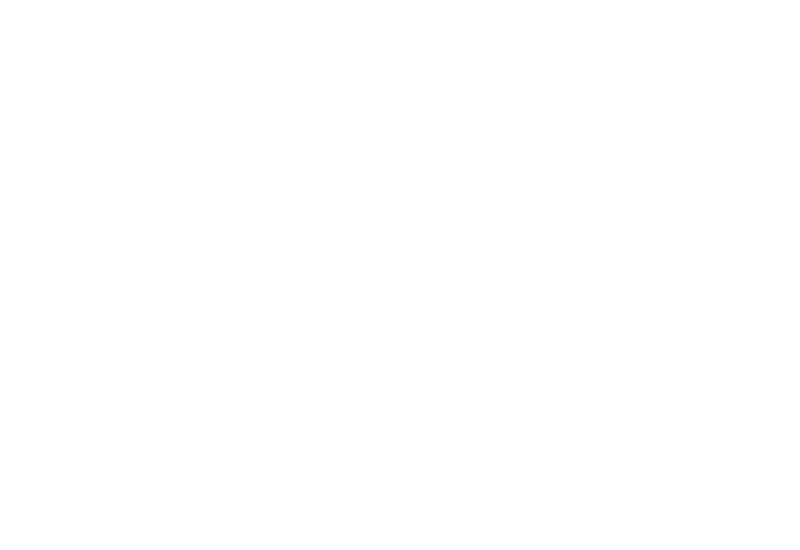

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [383]:
#Generates profile reports from test data
pandas_profiling.ProfileReport(test_df)




From this report we can notice:
<br>
    * We don't have missing values in our dataset
    <br>
    * The values of energy consumed seems correct and it is distrubuted in a range of [6400 8500] (in both the training and testing set) .
    <br>
    * The energy and enthalpy variables are highly correlated espacially in the training dataset.
    The correlation between these two variable in train set = 0.480433 and in the test set = -0.27703 => the correlation in test set is lower
    <br>
    * The training set contains only one class (good energy consumption)
    <br>
    * The testing set contains two classes:
    <br>
        good energy consumption
        <br>
        excessive energy consumption
        <br>
    => So we can adress this problem as an anomaly detection problem
    
    
    

In [7]:
#get the pairwise correlation of all columns in the dataframe
train_df.corr()

energy  enthalpy
energy    1.000000  0.480433
enthalpy  0.480433  1.000000

In [8]:
test_df.corr()

energy  enthalpy
energy    1.00000  -0.27703
enthalpy -0.27703   1.00000

# data visualization

<IPython.core.display.Javascript object>


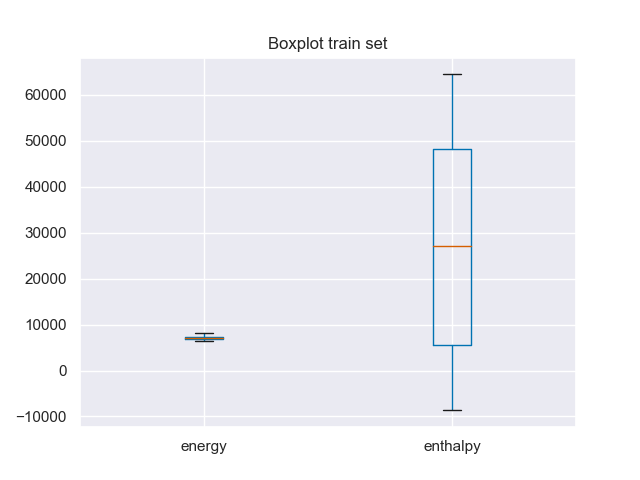

<AxesSubplot:title={'center':'Boxplot train set'}>

In [9]:
plt.figure()
plt.title('Boxplot train set')
train_df.boxplot()

<IPython.core.display.Javascript object>


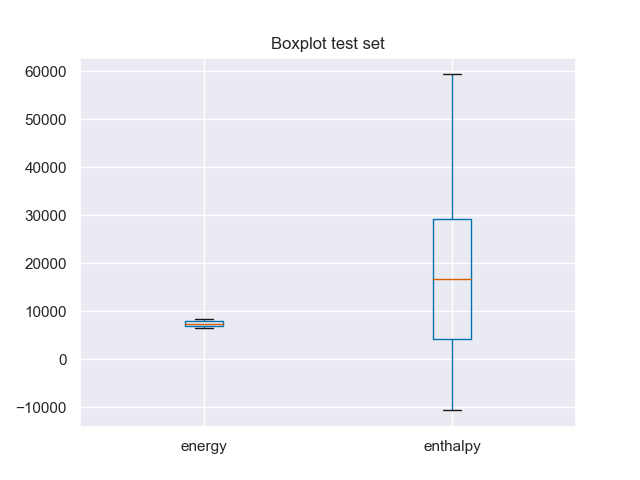

<AxesSubplot:title={'center':'Boxplot test set'}>

In [10]:
plt.figure()
plt.title('Boxplot test set')
test_df.boxplot()

In this case, it is not possible to identify the outlier directly from investigation one variable at the time
<br>
It is the combinaision of the energy and enthalpy variables that allows us to easily identify the anomaly

<IPython.core.display.Javascript object>


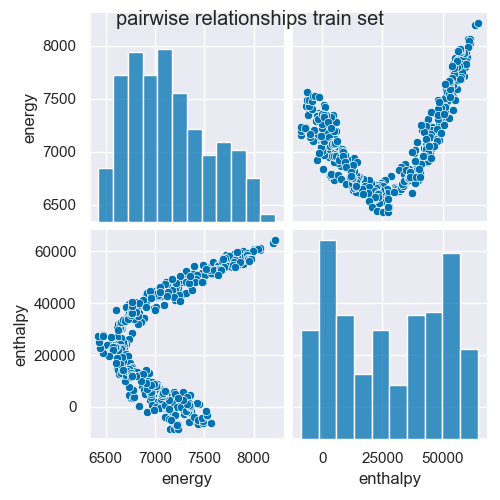

Text(0.5, 0.98, 'pairwise relationships train set')

In [12]:
g = sns.pairplot(train_df)
g.fig.suptitle("pairwise relationships train set")

<IPython.core.display.Javascript object>


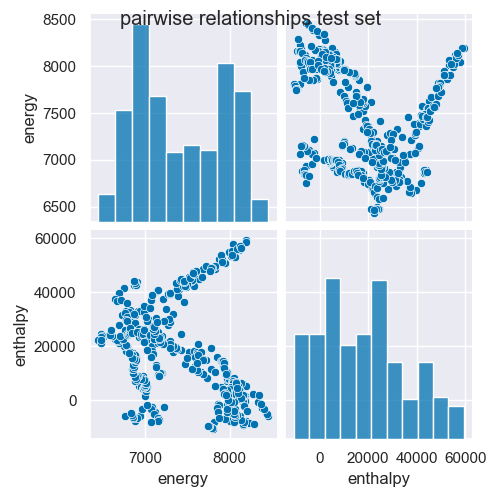

Text(0.5, 0.98, 'pairwise relationships test set')

In [14]:
g = sns.pairplot(test_df)
g.fig.suptitle("pairwise relationships test set")

<IPython.core.display.Javascript object>


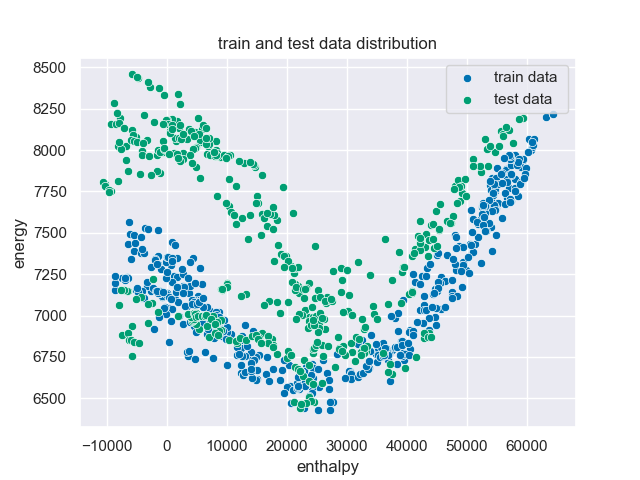

In [15]:
plt.figure()
plt.title('train and test data distribution')
sns.scatterplot(x="enthalpy", y="energy", data=train_df);
sns.scatterplot(x="enthalpy", y="energy", data=test_df);
plt.legend(labels=['train data ', 'test data'])

# Build model

It is become quite easy to visually identify abnormal consumption through data points located outside the typical distribution
<br>
We have only two variables and we can clearly visualize the relation between them, so we can use linear regression to fit data, then we calculate the residual value.
<br>
By examinate the distribution of the residual values, we can chose a cutoff value or threshold.
<br>
Every sample with residual value exceds the cutoff value is considered as excessive consumption
<br>
For this problem, linear regression model can reach very goods results and we don't have to use more complicated model (Auto-encoder for example)

## linear regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [17]:
model = LinearRegression()

In [19]:
#create polynominal features
poly = PolynomialFeatures(degree=4)
poly_train = poly.fit_transform(train_df['enthalpy'].values.reshape(-1, 1))

poly_test = poly.transform(test_df['enthalpy'].values.reshape(-1, 1))

In [21]:
#fit the model
model.fit(poly_train, train_df['energy'])

LinearRegression()

In [22]:
#prediction
train_pred = model.predict(poly_train)

test_pred = model.predict(poly_test)

In [23]:
#train set
df_pred_train = train_df.copy()
df_pred_train['energy_pred'] = train_pred

#get residual values for train set
df_pred_train["Residual"] = df_pred_train["energy"] - df_pred_train["energy_pred"]

In [24]:
df_pred_train.head()

date       energy      enthalpy  energy_pred   Residual
0  2019-06-02  6661.954286  30488.616385  6636.880547  25.073738
1  2019-06-03  6663.454286  30338.174100  6634.557824  28.896461
2  2019-06-04  6653.537143  30670.887292  6639.784463  13.752680
3  2019-06-05  6643.868571  30807.607844  6642.027194   1.841377
4  2019-06-06  6616.860000  30775.883551  6641.501871 -24.641871

<IPython.core.display.Javascript object>


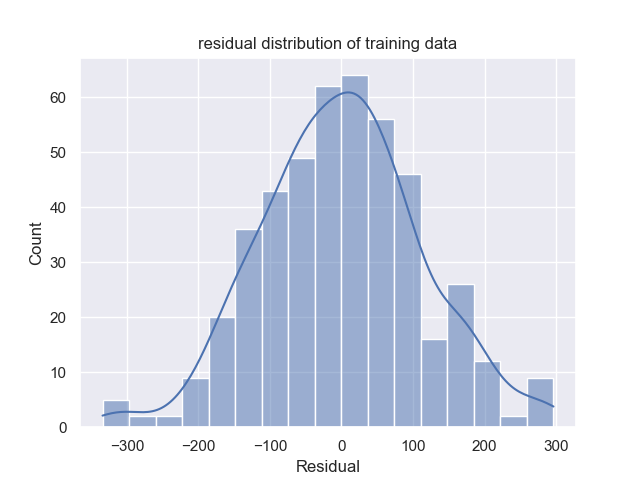

Text(0.5, 1.0, 'residual distribution of training data')

In [73]:
plt.figure()
sns.histplot(data=df_pred_train['Residual'],kde=True)
plt.title('residual distribution of training data')



From this fig, we can notice that the residual values follow a gaussian distribution, so we can use the standard deviation to define the cutoff value.
<br>
    1 Standard Deviation from the Mean: 68%
    <br>
    2 Standard Deviations from the Mean: 95%
    <br>
    3 Standard Deviations from the Mean: 99.7%


In [28]:
from numpy import std
std = std(df_pred_train["Residual"])

print('standard deviation = ',std)

standard deviation =  111.84052961905431


In [31]:
df_pred_test = test_df.copy()
df_pred_test['energy_pred'] = test_pred
#get residual
df_pred_test["Residual"] = df_pred_test["energy"] - df_pred_test["energy_pred"]

<IPython.core.display.Javascript object>


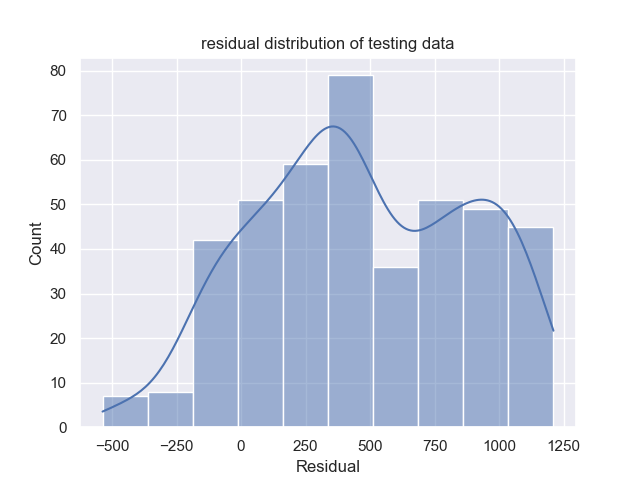

Text(0.5, 1.0, 'residual distribution of testing data')

In [74]:
plt.figure()
sns.histplot(data=df_pred_test['Residual'],kde=True)
plt.title('residual distribution of testing data')

cutoff value =  223.68105923810862


<IPython.core.display.Javascript object>


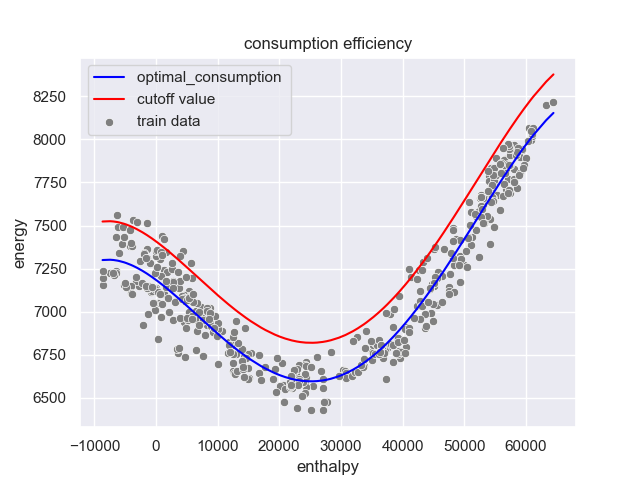

In [76]:
#train data

cutoff = 2*std
print('cutoff value = ', cutoff)

plt.figure()
plt.title('consumption efficiency')
sns.scatterplot(x="enthalpy", y="energy", data=df_pred_train, color='grey')
sns.lineplot(x="enthalpy", y="energy_pred", data = df_pred_train, color='blue')
sns.lineplot(x="enthalpy", y="energy_pred", data = pd.concat([df_pred_train['energy_pred']+cutoff, 
                                            df_pred_train['enthalpy']],axis=1, join='inner'), color='red')

plt.legend(labels=['optimal_consumption ', 'cutoff value', 'train data'])

cutoff value =  190.12890035239232


<IPython.core.display.Javascript object>


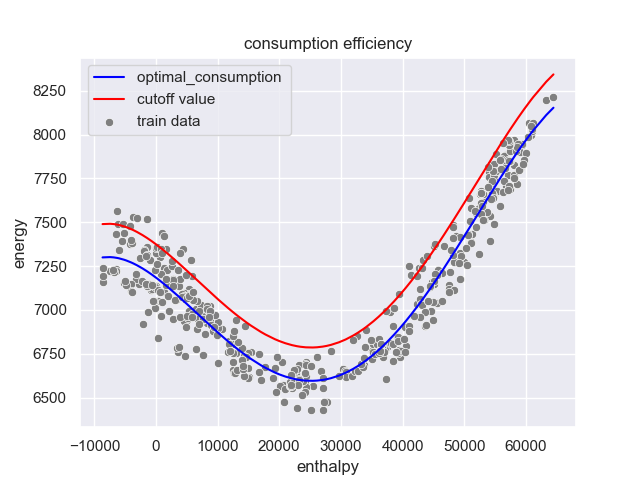

In [79]:
#train data

cutoff = 1.7*std
print('cutoff value = ', cutoff)

plt.figure()
plt.title('consumption efficiency')
sns.scatterplot(x="enthalpy", y="energy", data=df_pred_train, color='grey')
sns.lineplot(x="enthalpy", y="energy_pred", data = df_pred_train, color='blue')
sns.lineplot(x="enthalpy", y="energy_pred", data = pd.concat([df_pred_train['energy_pred']+cutoff, 
                                            df_pred_train['enthalpy']],axis=1, join='inner'), color='red')

plt.legend(labels=['optimal_consumption ', 'cutoff value', 'train data'])

After some visualisations using differet value of cutoff, we notice that the value 1.7*std gives better results
<br>
The energy isn't only related to the enthalpy, it is also affected  by the nunber of customers and how much time they 
spend, also it can depends on the sunset time which is different between summer and winter....
<br>
That's explain the presence of some outliers in the training set

<IPython.core.display.Javascript object>


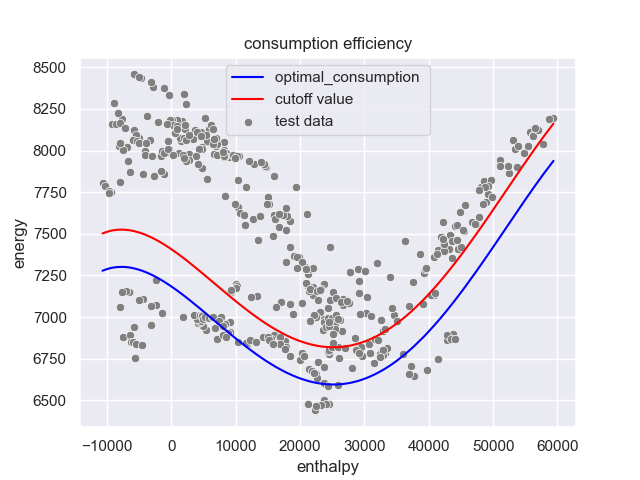

In [43]:
#test data
plt.figure()
plt.title('consumption efficiency')

sns.scatterplot(x="enthalpy", y="energy", data=df_pred_test, color='grey')
sns.lineplot(x="enthalpy", y="energy_pred", data = df_pred_test, color='blue')
sns.lineplot(x="enthalpy", y="energy_pred", data = pd.concat([df_pred_test['energy_pred']+cutoff, 
                                            df_pred_test['enthalpy']],axis=1, join='inner'), color='red')

plt.legend(labels=['optimal_consumption ', 'cutoff value', 'test data'])

In [44]:
def consumption_efficiency(enthalpy, energy):
    enthalpy_poly = poly.transform(np.array(enthalpy).reshape(-1, 1))
    energy_pred = model.predict(enthalpy_poly)
    residual = energy - energy_pred
    if residual < cutoff:
        print('optimal consumption')
    else:
        print('excessive consumption, a normal consumption should be less then:', int(cutoff + energy_pred))

In [45]:
consumption_efficiency(50000,7700)

excessive consumption, a normal consumption should be less then: 7643


In [89]:
def days_consumption(df):
    
    poly_df = poly.transform(df['enthalpy'].values.reshape(-1, 1))
    pred = model.predict(poly_df)
    df["energy_pred"] = pred
    df["Residual"] = df["energy"] - df["energy_pred"]
    
    df['efficient'] = df['Residual'] < cutoff
    #if the consumption is normal => efficient = True, else efficient = False
    optimal_days = df.loc[df['efficient'] == True, 'date']
    not_optimal_days = df.loc[df['efficient'] == False, 'date']
    test_output = df.copy()
    return (test_output,optimal_days,not_optimal_days)


In [83]:
#optimal_days
days_consumption(test_df)[1]

0      2019-02-22
1      2019-02-23
2      2019-02-24
3      2019-02-25
4      2019-02-26
          ...    
118    2020-09-21
127    2020-09-30
133    2020-10-06
134    2020-10-07
400    2021-06-30
Name: date, Length: 115, dtype: object

In [84]:
#not_optimal_days
days_consumption(test_df)[2]

57     2019-04-20
88     2019-05-21
89     2019-05-22
90     2019-05-23
91     2019-05-24
          ...    
422    2021-07-22
423    2021-07-23
424    2021-07-24
425    2021-07-25
426    2021-07-26
Name: date, Length: 312, dtype: object

By chosing more than one catoff value, we can define several interval of consumption (low, optimal, litle bitexcessive, to excessive)

In [107]:
test_out,_,_ = days_consumption(test_df)
test_out.set_index('date', inplace=True,drop=True)
test_out.sort_values(by="date", inplace=True)

In [109]:
test_out.to_csv('test_out.csv')